In [1]:
# Basic imports
import geopandas as gpd
from pathlib import Path

# Library imports
from geograypher.cameras.derived_cameras import MetashapeCameraSet
from geograypher.meshes import TexturedPhotogrammetryMesh
from geograypher.utils.geospatial import ensure_geometric_CRS
from geograypher.utils.visualization import show_segmentation_labels
from geograypher.constants import (
    EXAMPLE_LABELS_FILENAME,
    EXAMPLE_MESH_FILENAME,
    EXAMPLE_CAMERAS_FILENAME,
    EXAMPLE_DTM_FILE,
    EXAMPLE_IMAGE_FOLDER,
    EXAMPLE_STANDARDIZED_LABELS_FILENAME,
    EXAMPLE_LABELED_MESH_FILENAME,
    EXAMPLE_RENDERED_LABELS_FOLDER,
    TWENTY_CLASS_VIS_KWARGS,
)

# Set constants
You should be able to define most of the behavior from these constants

In [2]:
## Parameters to control the outputs
# Repeat the labeling process
RETEXTURE = True
# Points less than this height above the DTM are considered ground
# Something is off about the elevation between the mesh and the DTM, this should be a threshold in meters above ground
HEIGHT_ABOVE_GROUND_THRESH = 2
# The image is downsampled to this fraction for accelerated rendering
RENDER_IMAGE_SCALE = 1
# Cameras within this distance of the traing data are used in the rendering process
BUFFER_RADIUS_METER = 50
# Tree Radius
TREE_RADIUS_METERS = 2.5
# Downsample target
DOWNSAMPLE_TARGET = 0.1

## Define the inputs
# The input labels
LABELS_FILENAME = EXAMPLE_LABELS_FILENAME
# Render data from this column in the geofile to each image
LABEL_COLUMN_NAME = "Species"
# The mesh exported from Metashape
MESH_FILENAME = EXAMPLE_MESH_FILENAME
# The camera file exported from Metashape
CAMERAS_FILENAME = EXAMPLE_CAMERAS_FILENAME
# The digital elevation map exported by Metashape
DTM_FILE = EXAMPLE_DTM_FILE
# The image folder used to create the Metashape project
IMAGE_FOLDER = EXAMPLE_IMAGE_FOLDER

## Define the intermediate results
# Processed geo file
STANDARDIZED_LABELS_FILENAME = EXAMPLE_STANDARDIZED_LABELS_FILENAME
# Where to save the mesh after labeling
LABELED_MESH_FILENAME = EXAMPLE_LABELED_MESH_FILENAME
# Where to save the rendering label images
RENDER_FOLDER = EXAMPLE_RENDERED_LABELS_FOLDER

# Geospatial processing

Preprocess the geospatial data to be as expected.

<Axes: >

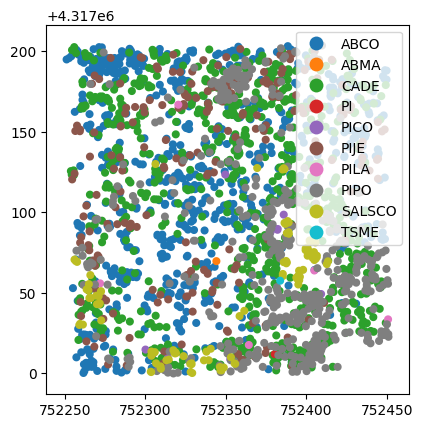

In [3]:
# Load the data
gdf = gpd.read_file(LABELS_FILENAME)
# Ensure that the CRS is geometric so we can buffer
gdf = ensure_geometric_CRS(gdf)

# Now create circles around each point
gdf["geometry"] = gdf["geometry"].buffer(TREE_RADIUS_METERS)

# Split
gdf = gdf.dissolve(LABEL_COLUMN_NAME, as_index=False)
# Drop all but the geometry and the species label
gdf = gdf.loc[:, gdf.columns.intersection([LABEL_COLUMN_NAME, "geometry"])]
# Write out the sandarized file
gdf.to_file(STANDARDIZED_LABELS_FILENAME)
# Show
gdf.plot(LABEL_COLUMN_NAME, legend=True)

# Load the mesh and read texture from geopolygon

In [4]:
# Create a labeled version of the mesh from the field data
# if not present or requested
if not Path(LABELED_MESH_FILENAME).is_file() or RETEXTURE:
    # Load the downsampled mesh and apply the texture from the vector file
    mesh = TexturedPhotogrammetryMesh(
        MESH_FILENAME,
        downsample_target=DOWNSAMPLE_TARGET,
        texture=STANDARDIZED_LABELS_FILENAME,
        texture_column_name=LABEL_COLUMN_NAME,
        transform_filename=CAMERAS_FILENAME,
    )
    # Get the vertex textures from the mesh
    texture_verts = mesh.get_texture(
        request_vertex_texture=True, try_verts_faces_conversion=False
    )
    mesh.label_ground_class(
        DTM_file=DTM_FILE,
        height_above_ground_threshold=HEIGHT_ABOVE_GROUND_THRESH,
        only_label_existing_labels=True,
        ground_class_name="GROUND",
        set_mesh_texture=True,
    )

    mesh.save_mesh(LABELED_MESH_FILENAME, save_vert_texture=True)
else:
    mesh = TexturedPhotogrammetryMesh(
        LABELED_MESH_FILENAME, transform_filename=CAMERAS_FILENAME
    )

Loading transform to EPSG:4326
Loading mesh
Reading the mesh


/ofo-share/repos-david/conda/envs/geograypher/lib/python3.9/site-packages/pyvista/plotting/plotter.py:149: UserWarning: 
This system does not appear to be running an xserver.
PyVista will likely segfault when rendering.

Try starting a virtual frame buffer with xvfb, or using
  ``pyvista.start_xvfb()``

  warnings.warn(


Selecting an ROI from mesh
Downsampling the mesh
Extracting faces from mesh
Loading texture
Trying to read texture as a scalar from the pyvista mesh:
- failed
Trying to read texture as a numpy file:
- failed
Trying to read texture as vector file:
- success


Sampling values from raster /ofo-share/repos-david/geograypher/data/example_Emerald_Point_data/inputs/dtm.tif: 100%|██████████| 71620/71620 [00:02<00:00, 25287.60it/s]


discrete texture, saving classes
Saving IDs_to_labels to labeled_mesh_IDs_to_labels.json


# Load a set of cameras and downsample them to the region around annotations

/ofo-share/repos-david/conda/envs/geograypher/lib/python3.9/site-packages/pyvista/plotting/plotter.py:149: UserWarning: 
This system does not appear to be running an xserver.
PyVista will likely segfault when rendering.

Try starting a virtual frame buffer with xvfb, or using
  ``pyvista.start_xvfb()``

  warnings.warn(


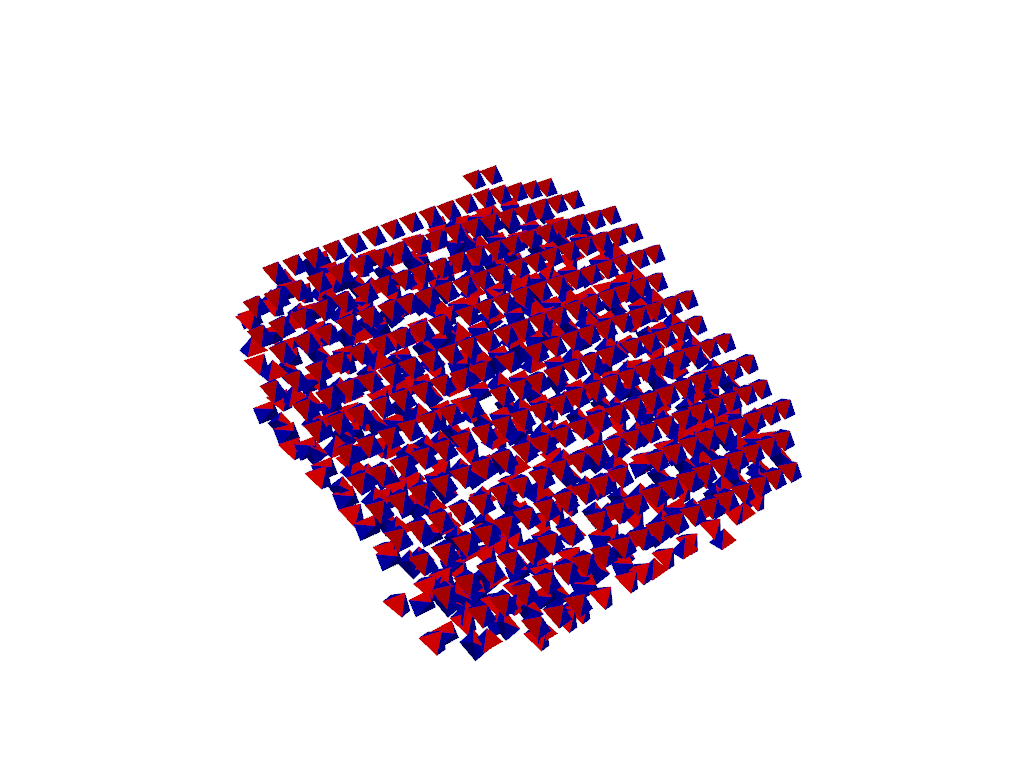

In [5]:
# Create camera set
camera_set = MetashapeCameraSet(CAMERAS_FILENAME, IMAGE_FOLDER)
# Extract cameras near the training data
training_camera_set = camera_set.get_subset_ROI(
    ROI=STANDARDIZED_LABELS_FILENAME, buffer_radius_meters=BUFFER_RADIUS_METER
)
training_camera_set.vis(force_xvfb=True, frustum_scale=0.5)

# Show the mesh

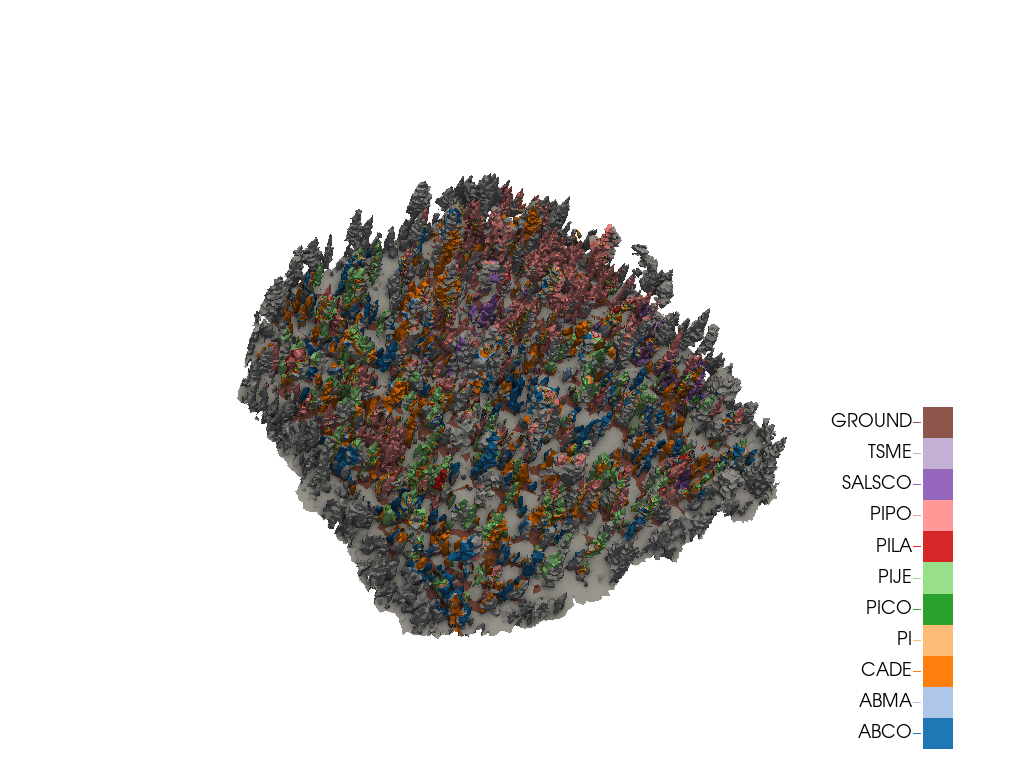

In [6]:
# You can include the camera set, but it's cleaner without it
mesh.vis(camera_set=None, force_xvfb=True)

# Render the labels onto the images

In [7]:
mesh.save_renders(
    camera_set=training_camera_set,
    render_image_scale=RENDER_IMAGE_SCALE,
    save_native_resolution=True,
    output_folder=RENDER_FOLDER,
)

Saving renders to /ofo-share/repos-david/geograypher/data/example_Emerald_Point_data/intermediate_results/rendered_labels
discrete texture, saving classes
Saving IDs_to_labels to /ofo-share/repos-david/geograypher/data/example_Emerald_Point_data/intermediate_results/rendered_labels/IDs_to_labels.json


Computing and saving renders: 100%|██████████| 772/772 [14:59<00:00,  1.16s/it]


# Show some of the rendered labels

In [8]:
show_segmentation_labels(
    label_folder=RENDER_FOLDER,
    image_folder=IMAGE_FOLDER,
    num_show=10,
    label_suffix=".npy",
)

ValueError: operands could not be broadcast together with shapes (3648,4864,3) (3648,4864,1,3) 